# Data Utility Learning

This notebooks introduces Data Utility Learning a method for improving the efficiency in computing Data Shapley values by learning to estimate the performance of a learning algorithm on unseen data combinations (i.e. subsets of the dataset). The method was described in the paper [Improving Cooperative Game Theory-Based Data Valuation Via Data Utility Learning](https://arxiv.org/pdf/2107.06336v2.pdf).

The Shapley value $\phi_i(v)$ for data point $i$ is defined as:

$$\phi_i(v) = \frac{1}{n} \Sigma_{S \subseteq N \setminus \{i\}} \frac{1}{\binom{n-1}{|S|}} [v(S \cup \{i\}) − v(S)]$$

For Data Utility Learning, we first start by sampling utility samples: 

$$S_{train} = \{(S_i, v(S_i))\}_{i}^{m_{train}}$$

where $m_{train}$ is the number of utility samples and is called the training budget.

The subsets are then transformed into boolean vectors in which a $1$ at index $j$ means that the $j^{th}$ sample of the dataset is present in the subset:

$$S_i \mapsto \{ 0, 1 \}^{n}$$

After that, we fit a regression model, $\tilde{v}$ that we call the data utility model, on the collected samples
and use that instead of predict the utility for the remaining samples:

$$\tilde{v} : \{ 0, 1 \}^{n} \mapsto [0, 1] $$

The main assumption here is that it is much faster to fit a model and use it to predict the utility than it is to compute the exact utility.

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import os
import random
from concurrent.futures import as_completed, ProcessPoolExecutor
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning
from tqdm.auto import tqdm

from valuation.utils import Dataset, Utility, DataUtilityLearning, top_k_value_accuracy
from valuation.shapley import get_shapley_values

simplefilter("ignore", category=ConvergenceWarning)

In [3]:
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams["font.size"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15

## Constants

In [4]:
random_state = 24

if os.environ.get("CI"):
    train_size = 5
    training_budget_values = np.arange(2, 10, 2)
    n_iterations = 1
else:
    train_size = 15
    training_budget_values = np.arange(100, 8000, 250)
    n_iterations = 10


mlp_kwargs = dict(
    hidden_layer_sizes=(20, 10),
    activation="relu",
    solver="adam",
    learning_rate_init=0.001,
    batch_size=32,
    max_iter=800,
)

In [5]:
random.seed(random_state)
np.random.seed(random_state)

## Dataset

Just like in the paper, we take 15 samples from the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) and compute their Data Shapley values by using all the remaining samples as test set for computing the utility, which in this case is accuracy.

In [6]:
X, y = load_iris(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, random_state=random_state, stratify=y
)
dataset = Dataset(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

## Model

Also just like in the paper, we train fit a Support-Vector Classifier on the training data and we obtain an accuracy of around 92%

In [7]:
model = LinearSVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.9259259259259259

## Data Shapley

We start by defining the utility and computing the exact Data Shapley values

In [8]:
utility = Utility(
    model=LinearSVC(),
    data=dataset,
    enable_cache=False,
)

In [9]:
df = get_shapley_values(
    u=utility,
    mode="combinatorial_exact",
    progress=False,
)
df = df.set_index("data_key")
df = df.rename(columns={"shapley_dval": "exact"})

Then we compute the estimates of the Data Shapley values using the DataUtilityLearning wrapper which fits, just like in the paper, a Multi-Layer Perceptron (or Fully Connected Network) on a certain number, determined by `training_budget`, of utility samples (pairs of subset of training dataset and the corresponding utility).

In [10]:
for training_budget in tqdm(training_budget_values):

    def compute_shapley_values(utility: Utility, i: int):
        utility = DataUtilityLearning(
            u=utility, training_budget=training_budget, model=MLPRegressor(**mlp_kwargs)
        )

        dul_df = get_shapley_values(
            u=utility,
            mode="combinatorial_exact",
            progress=False,
        )
        dul_df = dul_df.set_index("data_key")
        dul_df = dul_df.rename(columns={"shapley_dval": f"{training_budget}_{i}"})
        return dul_df

    with ProcessPoolExecutor(4) as executor:
        futures = [
            executor.submit(compute_shapley_values, utility, i)
            for i in range(n_iterations)
        ]
        for future in as_completed(futures, timeout=8 * 60):
            dul_df = future.result()
            df = pd.concat([df, dul_df], axis=1)

  0%|          | 0/32 [00:00<?, ?it/s]

After, we compute the mean, minimum and maximum $L_1$ error for the different training budget values and plots the results

In [11]:
errors = np.zeros((len(training_budget_values), n_iterations), dtype=float)
accuracies = np.zeros((len(training_budget_values), n_iterations), dtype=float)

K = 3

for i in range(len(training_budget_values)):
    for j in range(n_iterations):
        y_true = df["exact"].values
        y_estimated = df[f"{training_budget_values[i]}_{j}"].values
        errors[i, j] = np.linalg.norm(y_true - y_estimated, ord=2)
        accuracies[i, j] = top_k_value_accuracy(y_true, y_estimated, k=K)

error_from_mean = np.linalg.norm(df["exact"].values - df["exact"].values.mean(), ord=2)

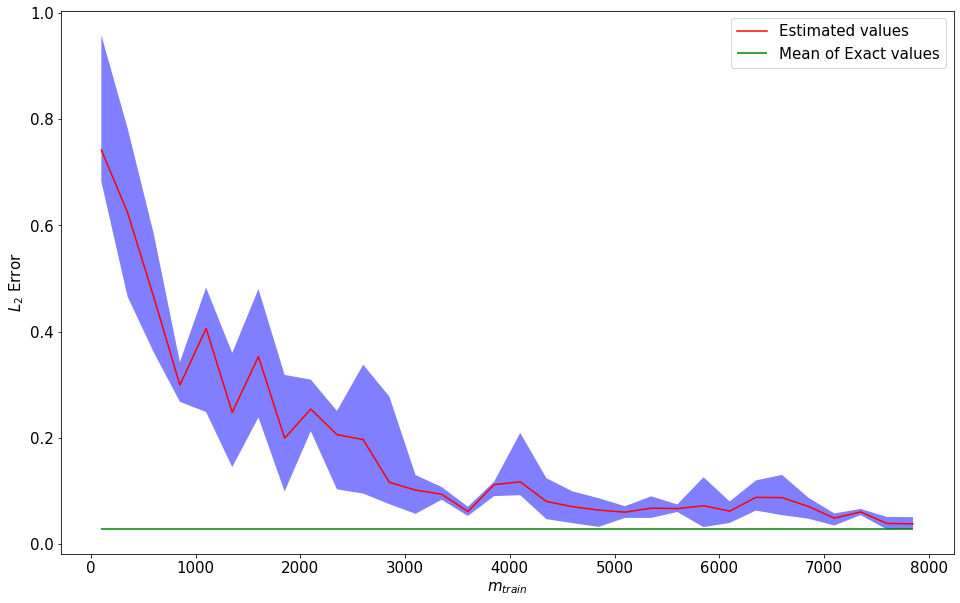

In [12]:
fig, ax = plt.subplots()
ax.plot(training_budget_values, errors.mean(axis=1), "r", label="Estimated values")
ax.hlines(
    error_from_mean,
    training_budget_values.min(),
    training_budget_values.max(),
    "g",
    label="Mean of Exact values",
)
ax.fill_between(
    training_budget_values,
    errors.min(axis=1),
    errors.max(axis=1),
    facecolor="b",
    alpha=0.5,
)
ax.set_xlabel("$m_{train}$")
ax.set_ylabel("$L_2$ Error")
plt.legend()
plt.show()

As can be seen, the above plot matches the plot in the paper and thus shows that the method works for estimating the Data Shapley values.

Next, we plot the accuracy for the Top 3 predicted highest value data samples. 

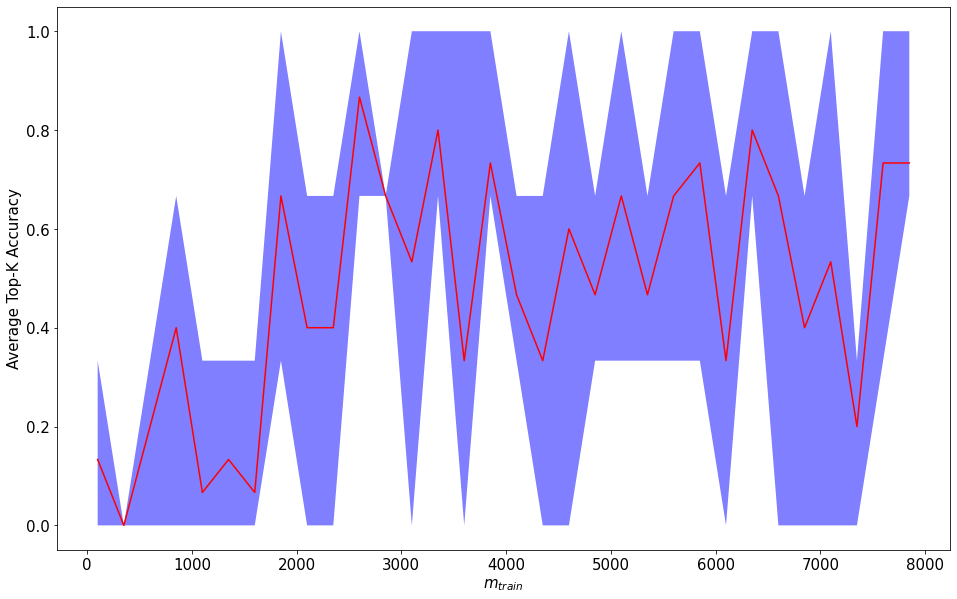

In [13]:
fig, ax = plt.subplots()
ax.plot(training_budget_values, accuracies.mean(axis=1), "r", label="Estimated values")
ax.fill_between(
    training_budget_values,
    accuracies.min(axis=1),
    accuracies.max(axis=1),
    facecolor="b",
    alpha=0.5,
)
ax.set_xlabel("$m_{train}$")
ax.set_ylabel("Average Top-K Accuracy")
plt.show()

In [14]:
best_training_budget = training_budget_values[errors.mean(axis=1).argmin()]

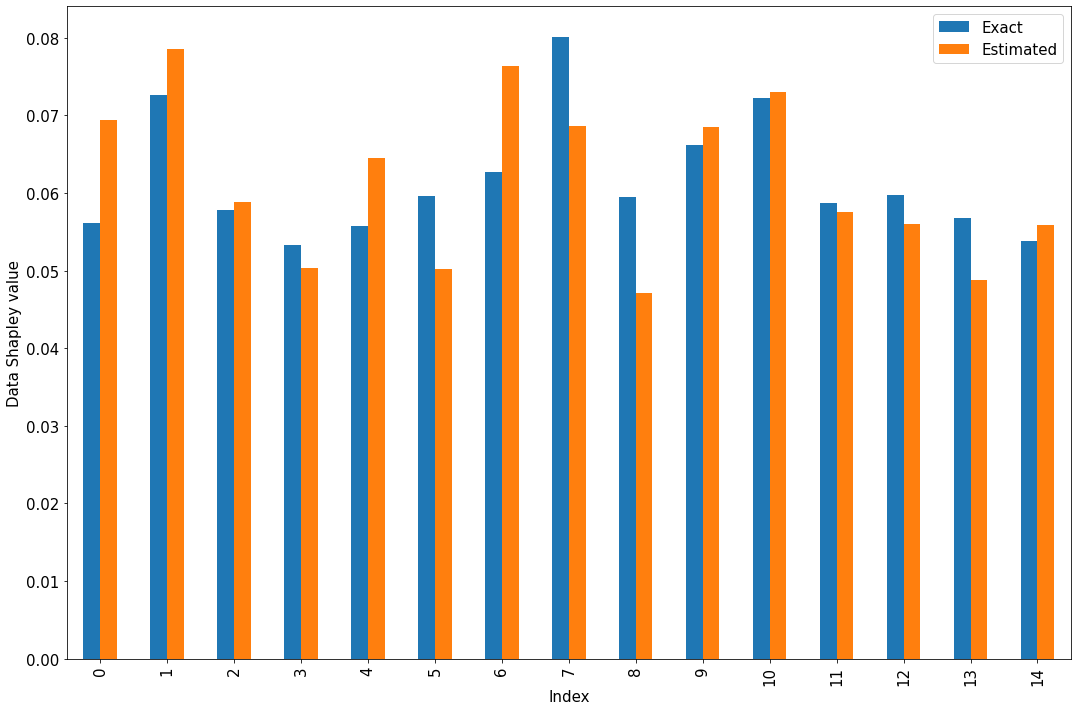

In [15]:
fig, ax = plt.subplots(figsize=(18, 12))
df.plot(y=["exact", f"{best_training_budget}_{0}"], kind="bar", ax=ax)
ax.set_xlabel("Index")
ax.set_ylabel("Data Shapley value")
plt.legend(["Exact", "Estimated"])
plt.show()

## Evaluation on anomalous data

One interesting way to assess the Data Utility Learning approach is to corrupt some of the data and monitor how the valuation score changes. To do this, we will take the sample with the highest score and change its label.

In [16]:
highest_value_index = df["exact"].argmax()
y_train_corrupted = dataset.y_train.copy()
y_train_corrupted[highest_value_index] = (
    y_train_corrupted[highest_value_index] + 1
) % 3

corrupted_dataset = Dataset(
    x_train=dataset.x_train,
    y_train=y_train_corrupted,
    x_test=dataset.x_test,
    y_test=dataset.y_test,
)

We retrain the model on the new dataset and notice that the accuracy decreased

In [17]:
model = LinearSVC()
model.fit(x_train, y_train_corrupted)
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.8296296296296296

After that, we recompute the scores of all samples using the exact method and the best training budget previously obtained and then plot the resulting scores.

In [18]:
utility = Utility(
    model=LinearSVC(),
    data=corrupted_dataset,
    enable_cache=False,
)

df_corrupted = get_shapley_values(
    u=utility,
    mode="combinatorial_exact",
    progress=False,
)
df_corrupted = df_corrupted.set_index("data_key")
df_corrupted = df_corrupted.rename(columns={"shapley_dval": "exact"})

utility = DataUtilityLearning(
    u=utility, training_budget=best_training_budget, model=MLPRegressor(**mlp_kwargs)
)

dul_df = get_shapley_values(
    u=utility,
    mode="combinatorial_exact",
    progress=False,
)
dul_df = dul_df.set_index("data_key")
dul_df = dul_df.rename(columns={"shapley_dval": "estimated"})
df_corrupted = pd.concat([df_corrupted, dul_df], axis=1)

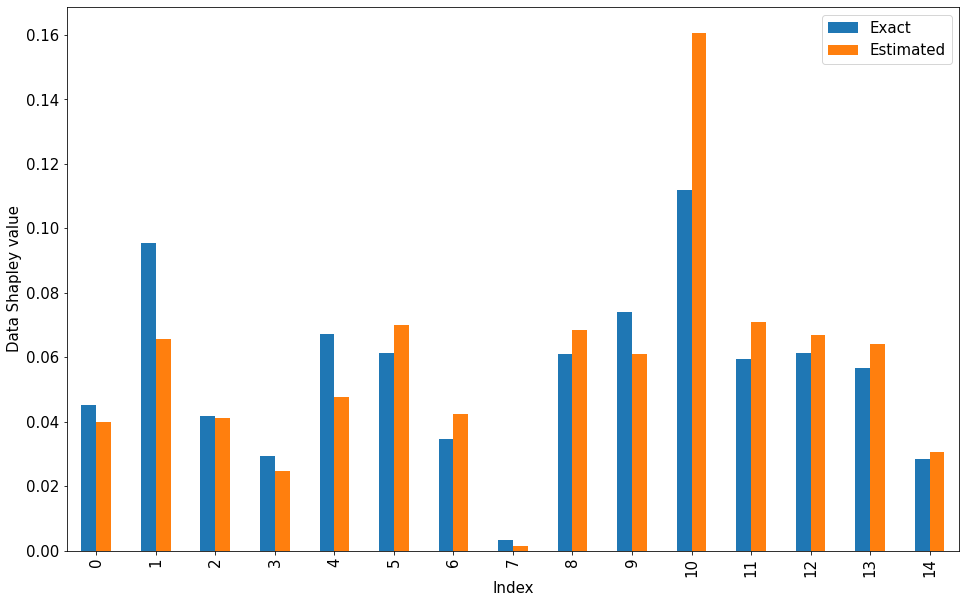

In [19]:
fig, ax = plt.subplots()
df_corrupted.plot(y=["exact", "estimated"], kind="bar", ax=ax)
ax.set_xlabel("Index")
ax.set_ylabel("Data Shapley value")
plt.legend(["Exact", "Estimated"])
plt.show()

As can be seen in the above figure, both the exact method and the approximate method agree on the fact that the sample with the corrupted label has the lowest value in the dataset.

Still, this work is preliminary and the usefulness of Data Utility Learning remains to be tested in practice.
As can be seen in the first figure, the estimated utility's error doesn't go below the error of true utility mean.
This can either be due to the fact that for this dataset, all the utility values are close to each other and that's why the mean
is a better predictor or the method is not learning anything useful apart from the mean.